# Create Polygons From Clusters of Points
This would be useful for converting raster classification maps to polygons.


## Method 1
Based on https://gis.stackexchange.com/a/439834

In [151]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np

from sklearn.cluster import DBSCAN
import pandas as pd
from shapely.ops import unary_union

In [31]:
df = gpd.read_file('points.geojson')

df['xcoord'] = df.geometry.x
df['ycoord'] = df.geometry.y

In [32]:
#Cluster nearby points together
coords = df[['xcoord','ycoord']].values #Create a numpy array
db = DBSCAN(eps=175, min_samples=1).fit(coords) #Cluster the points. eps is max distance to cluster points together
cluster_labels = pd.Series(db.labels_).rename('cluster') #Extract cluster labels
df = pd.concat([df, cluster_labels], axis=1) #Add them to the points

In [33]:
# Unique cluster numbers
df.cluster.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64)

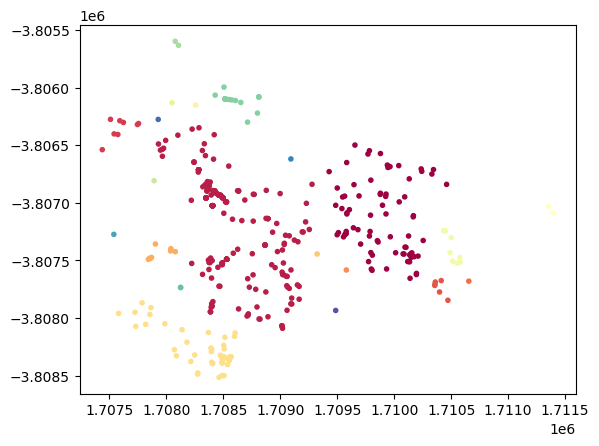

In [34]:
#Adjust eps and plot until it looks as good as possible
fig, ax = plt.subplots()
ax.scatter(x=df['xcoord'], y=df['ycoord'], c=df['cluster'], marker='.', cmap='Spectral')

In [36]:
#Create convex hulls from each cluster
hulls = [] #A list to hold clusterids and convex hull geometries
for clusterid, frame in df.loc[df['cluster']!=-1].groupby('cluster'): #For each cluster group except -1
    geom = unary_union(frame.geometry.tolist()).convex_hull #Create one multipoint and convex hull it
    hulls.append([clusterid, geom])
    
df2 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
gdf = gpd.GeoDataFrame(data=df2, geometry=df2['geometry'], crs=df.crs)


In [41]:
gdf

,cluster,geometry
0,0,"POLYGON ((1710139.394 -3807655.694, 1709806.14..."
1,1,"POLYGON ((1709020.305 -3808089.940, 1708388.08..."
2,2,"POLYGON ((1707438.636 -3806539.101, 1707510.75..."
3,3,"POLYGON ((1710471.532 -3807846.508, 1710398.29..."
4,4,POINT (1710655.031 -3807680.708)
5,5,POINT (1709580.396 -3807583.757)
6,6,"POLYGON ((1707843.452 -3807491.197, 1707904.83..."
7,7,POINT (1709324.401 -3807444.728)
8,8,"POLYGON ((1708463.718 -3808515.493, 1708275.15..."
9,9,POINT (1708257.658 -3806151.968)


<Axes: >

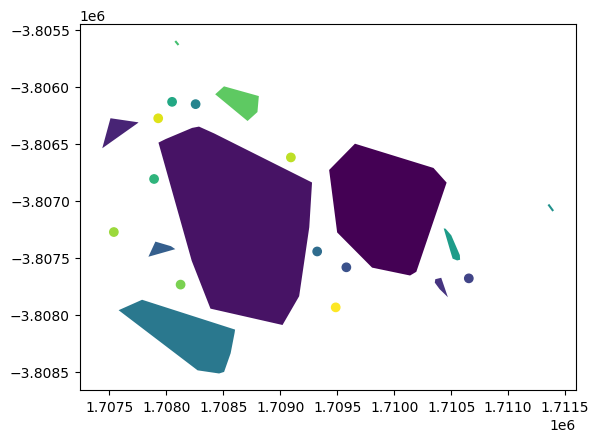

In [38]:
gdf.plot(column='cluster')

In [49]:
# Combine polygons into a single mulipolygon
# https://stackoverflow.com/a/74991509/8299958
# https://gis.stackexchange.com/a/413810
gdf2 = gdf.loc[gdf.geometry.geom_type=='Polygon'].dissolve()
gdf2

,geometry,cluster
0,"MULTIPOLYGON (((1707788.104 -3807868.576, 1708...",0


<Axes: >

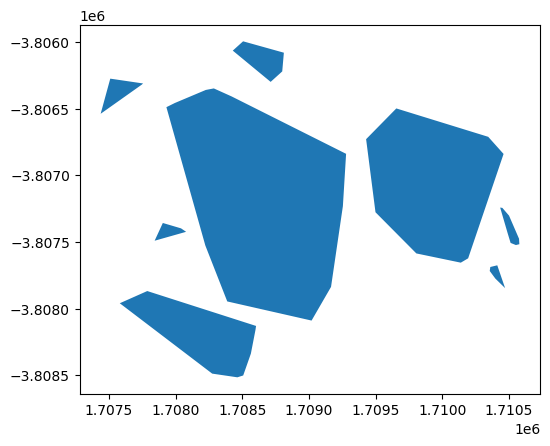

In [47]:
gdf2.plot()

In [48]:
# Save to file
gdf2.to_file('polygons_from_points.geojson', driver='GeoJSON')

## Method 2
1. Create GoeDataFrame of points
2. Buffer the points
3. Get the bounds of the buffered points
4. Convert the bounds of a point to a polygon
5. Merge all touching "buffer polygons" into individual polygons

References
* https://stackoverflow.com/a/72310089/8299958
* https://stackoverflow.com/a/68762419/8299958

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import Polygon


In [97]:
df = pd.DataFrame({'x': [0,1,3], 'y': [1,1,1]})

In [98]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))

<Axes: >

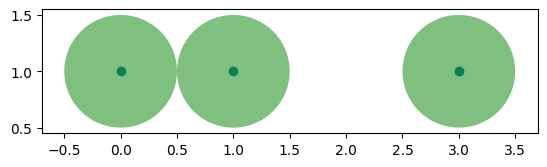

In [99]:
fig, ax = plt.subplots()
gdf.plot(ax=ax)
gdf.buffer(0.5).plot(ax=ax, color='green', alpha=0.5)

[(-0.5, 0.5), (0.5, 0.5), (0.5, 1.5), (-0.5, 1.5)]
[(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)]
[(2.5, 0.5), (3.5, 0.5), (3.5, 1.5), (2.5, 1.5)]


<Axes: >

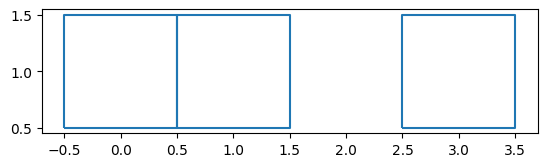

In [108]:
# https://stackoverflow.com/a/72310089/8299958

polygons = []

for row in gdf.index:
    # Get the X, Y coordinates of the point buffer bounds
    X1, Y1, X2, Y2 = gdf.iloc[[row]].buffer(0.5).total_bounds
    
    # Create the polygon; anti-clockwise from bottom-left
    polygon = [(X1, Y1), (X2, Y1), (X2, Y2), (X1, Y2)]
    print(polygon)
    polygons.append(Polygon(polygon))

gdf_poly = gpd.GeoDataFrame(geometry=polygons)

gdf_poly.boundary.plot()

<Axes: >

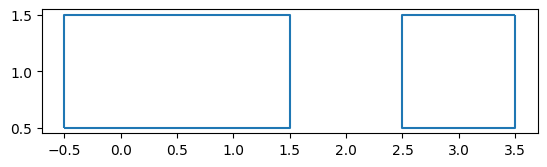

In [105]:
# Dissolve to create multipolygon with touching geometries merged
gdf_dissolved = gdf_poly.dissolve()
gdf_dissolved.boundary.plot()

In [106]:
gdf_dissolved.area

0    3.0
dtype: float64

### Apply to the test data

In [112]:
# Load the test data
da = rioxarray.open_rasterio('data/geotiff/test.tiff', default_name='class')
da

<xarray.DataArray 'class' (band: 1, y: 100, x: 100)>
[10000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.821e+06 1.821e+06 ... 1.824e+06 1.824e+06
  * y            (y) float64 -3.723e+06 -3.723e+06 ... -3.726e+06 -3.726e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      SVM_Class_linear

In [113]:
df = da.to_dataframe().reset_index()
df.head()

,band,y,x,spatial_ref,class
0,1,-3722685.0,1821465.0,0,5
1,1,-3722685.0,1821495.0,0,4
2,1,-3722685.0,1821525.0,0,4
3,1,-3722685.0,1821555.0,0,5
4,1,-3722685.0,1821585.0,0,5


In [114]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))
gdf.head()

,band,y,x,spatial_ref,class,geometry
0,1,-3722685.0,1821465.0,0,5,POINT (1821465.000 -3722685.000)
1,1,-3722685.0,1821495.0,0,4,POINT (1821495.000 -3722685.000)
2,1,-3722685.0,1821525.0,0,4,POINT (1821525.000 -3722685.000)
3,1,-3722685.0,1821555.0,0,5,POINT (1821555.000 -3722685.000)
4,1,-3722685.0,1821585.0,0,5,POINT (1821585.000 -3722685.000)


In [152]:
np.sort(gdf['class'].unique())

array([1, 2, 3, 4, 5, 6], dtype=uint8)

In [259]:
%%time

class_gdfs = []
classes = np.sort(gdf['class'].unique())[:2]

for cl in classes:
    # Intialise the list for the pixel polygons
    pixel_polygons = []
    for row in gdf[gdf['class']==cl].index:
        # Get the X, Y coordinates of the point buffer bounds
        X1, Y1, X2, Y2 = gdf.iloc[[row]].buffer(15).total_bounds
        
        # Create the polygon; anti-clockwise from bottom-left
        polygon = [(X1, Y1), (X2, Y1), (X2, Y2), (X1, Y2)]
        # print(polygon)
        # Append pixel polygon to output list
        pixel_polygons.append(Polygon(polygon))
    
    # Convert pixel_polygons to gdf and append to class_gdfs
    class_gdfs.append(gpd.GeoSeries(unary_union(pixel_polygons)))
    # class_gdfs.append(gpd.GeoDataFrame(geometry=unary_union(pixel_polygons)))
    # gdf_uu = gpd.GeoDataFrame(geometry=pixel_polygons)
    # gdf_uu.geometry = gdf_uu.geometry.unary_union()
    # class_gdfs.append(gdf_uu)

gdf_poly = gpd.GeoDataFrame(geometry=pd.concat(class_gdfs))
gdf_poly['class']=classes

CPU times: total: 1.64 s
Wall time: 2.01 s


In [207]:
import shapely
from shapely.ops import unary_union
shapely.geos.geos_version

(3, 11, 2)

<Axes: >

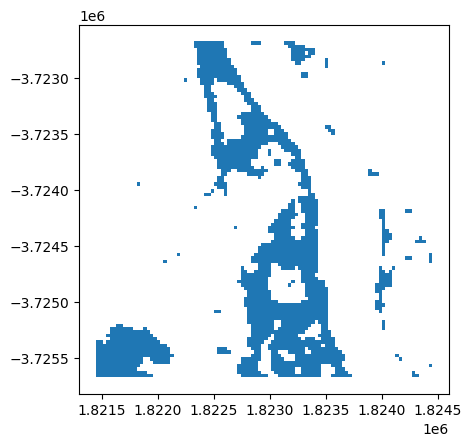

In [258]:
class_gdfs[1].plot()

In [247]:
gdf_poly

,geometry,class
0,"POLYGON ((1824090.000 -3725670.000, 1824120.00...",1
0,"POLYGON ((1824300.000 -3725670.000, 1824330.00...",2


In [224]:
gpd.GeoDataFrame(geometry=gdf_poly)

,geometry
0,"MULTIPOLYGON (((1822170.000 -3725640.000, 1822..."
0,"MULTIPOLYGON (((1821540.000 -3725670.000, 1821..."


<Axes: >

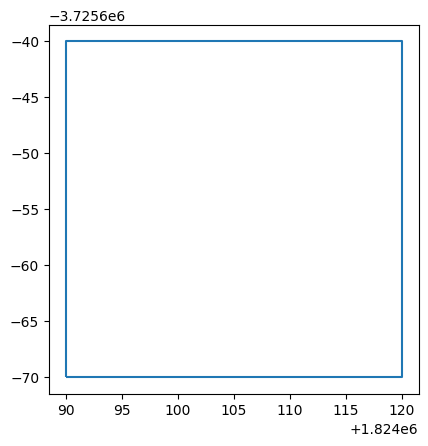

In [249]:
gdf_poly.iloc[[0]].boundary.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

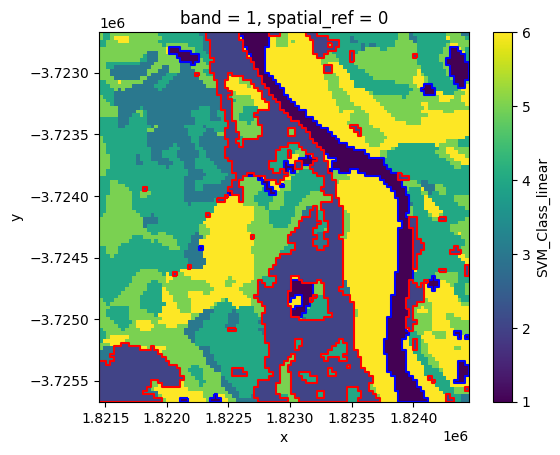

In [262]:
fig, ax = plt.subplots()
da.plot(ax=ax)
gdf_poly.boundary.plot(ax=ax, color=['blue','red','purple','orange'], alpha=1)

<Axes: >

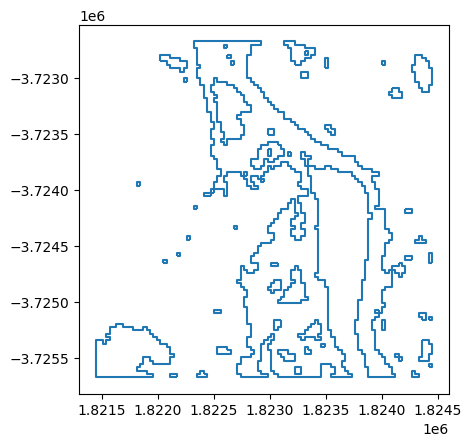

In [202]:
gdf_poly[gdf_poly['class']==2].boundary.plot()